# Advanced Lane Finding Project

The goals / steps of this project are the following:

- Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
- Apply a distortion correction to raw images.
- Use color transforms, gradients, etc., to create a thresholded binary image.
- Apply a perspective transform to rectify binary image ("birds-eye view").
- Detect lane pixels and fit to find the lane boundary.
- Determine the curvature of the lane and vehicle position with respect to center.
- Warp the detected lane boundaries back onto the original image.
- Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


In [3]:
%matplotlib inline

import cv2
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')



## Camera Calibration


Camara class defined in model.py provides the following methods:
- \_\_init__: The constructor method loads the calibration parameters if they are previouly stored.
- calibration(images, shape):  Usign a collection of chesboard images it computes the differents parameters needed by cv2.undistort. It also stores them for future use.
- imread(filename): Read an image and apply undistort

In [39]:
from model import Camera

camera = Camera()
calibration = camera.calibrate('camera_cal/*', shape=(9, 6))  # Calibration parameters are stored for future use

print([k for k in calibration.keys()])

['tvecs', 'rvecs', 'cameraMatrix', 'distCoeffs']


In [3]:
# The camera's calibration parameters are loaded at initialization
camera = Camera()
print([k for k in camera._calibration.keys()])

['rvecs', 'tvecs', 'distCoeffs', 'cameraMatrix']


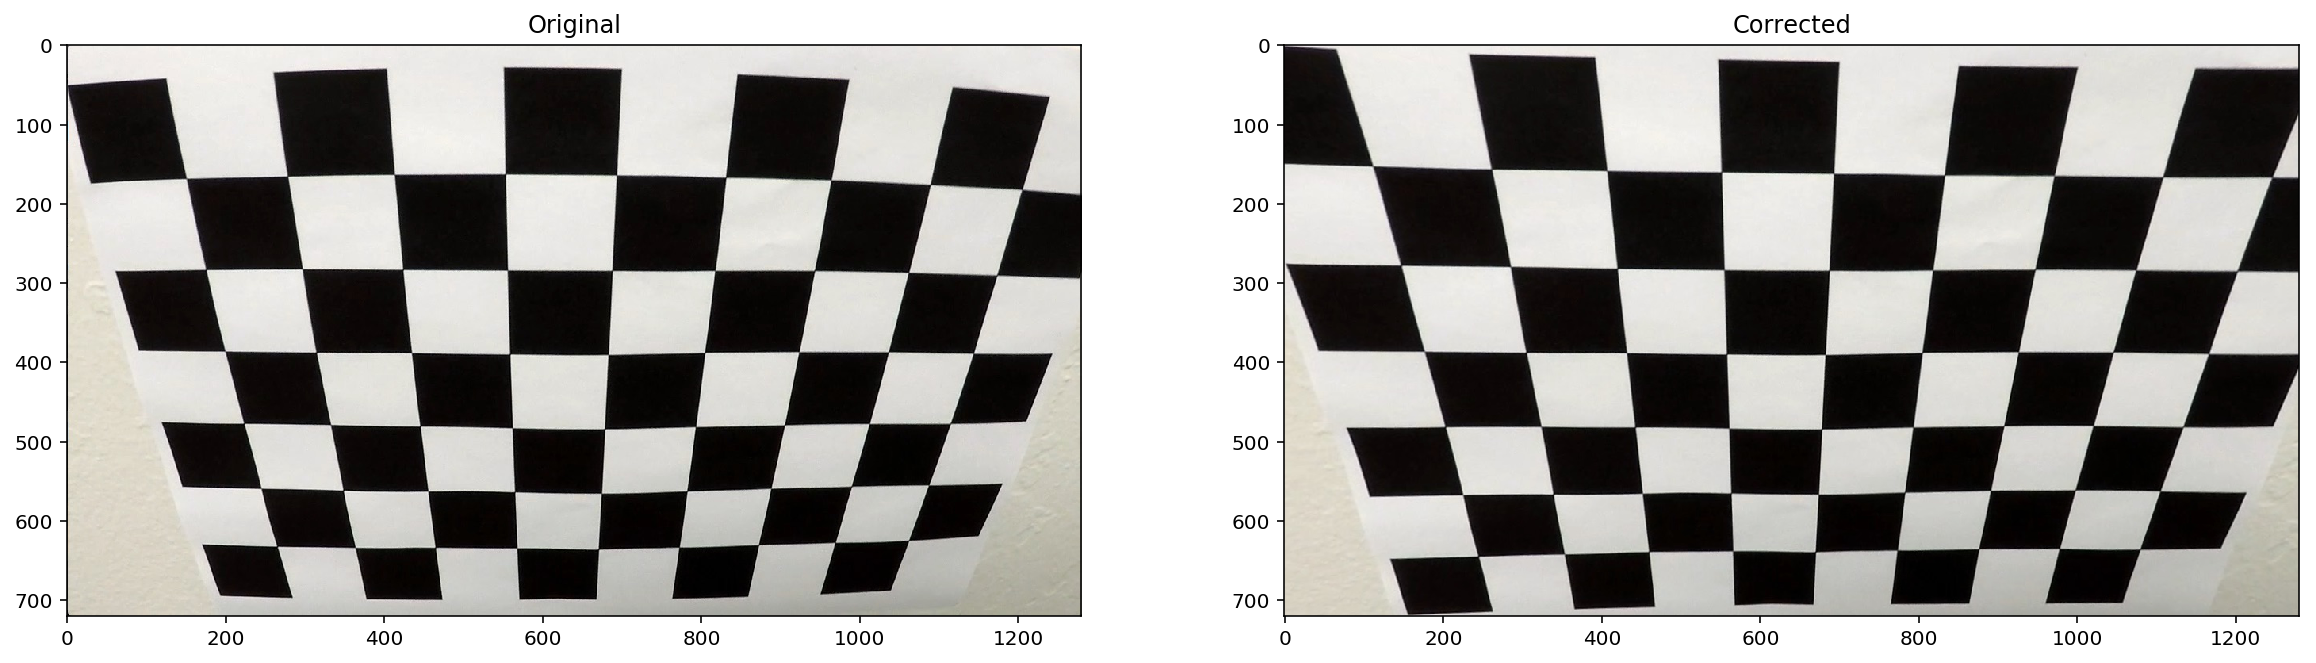

In [16]:
fig = plt.figure(figsize=(20, 10))

img = cv2.imread('camera_cal/calibration2.jpg')
fig.add_subplot(1, 2, 1).set_title('Original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

camera = Camera()  
image = camera.imread('camera_cal/calibration2.jpg')  # The image is automatically corrected

fig.add_subplot(1, 2, 2).set_title('Corrected')
image.show()

## Distortion Correction

Distotion correction is aplied automatically on Camera.imread()

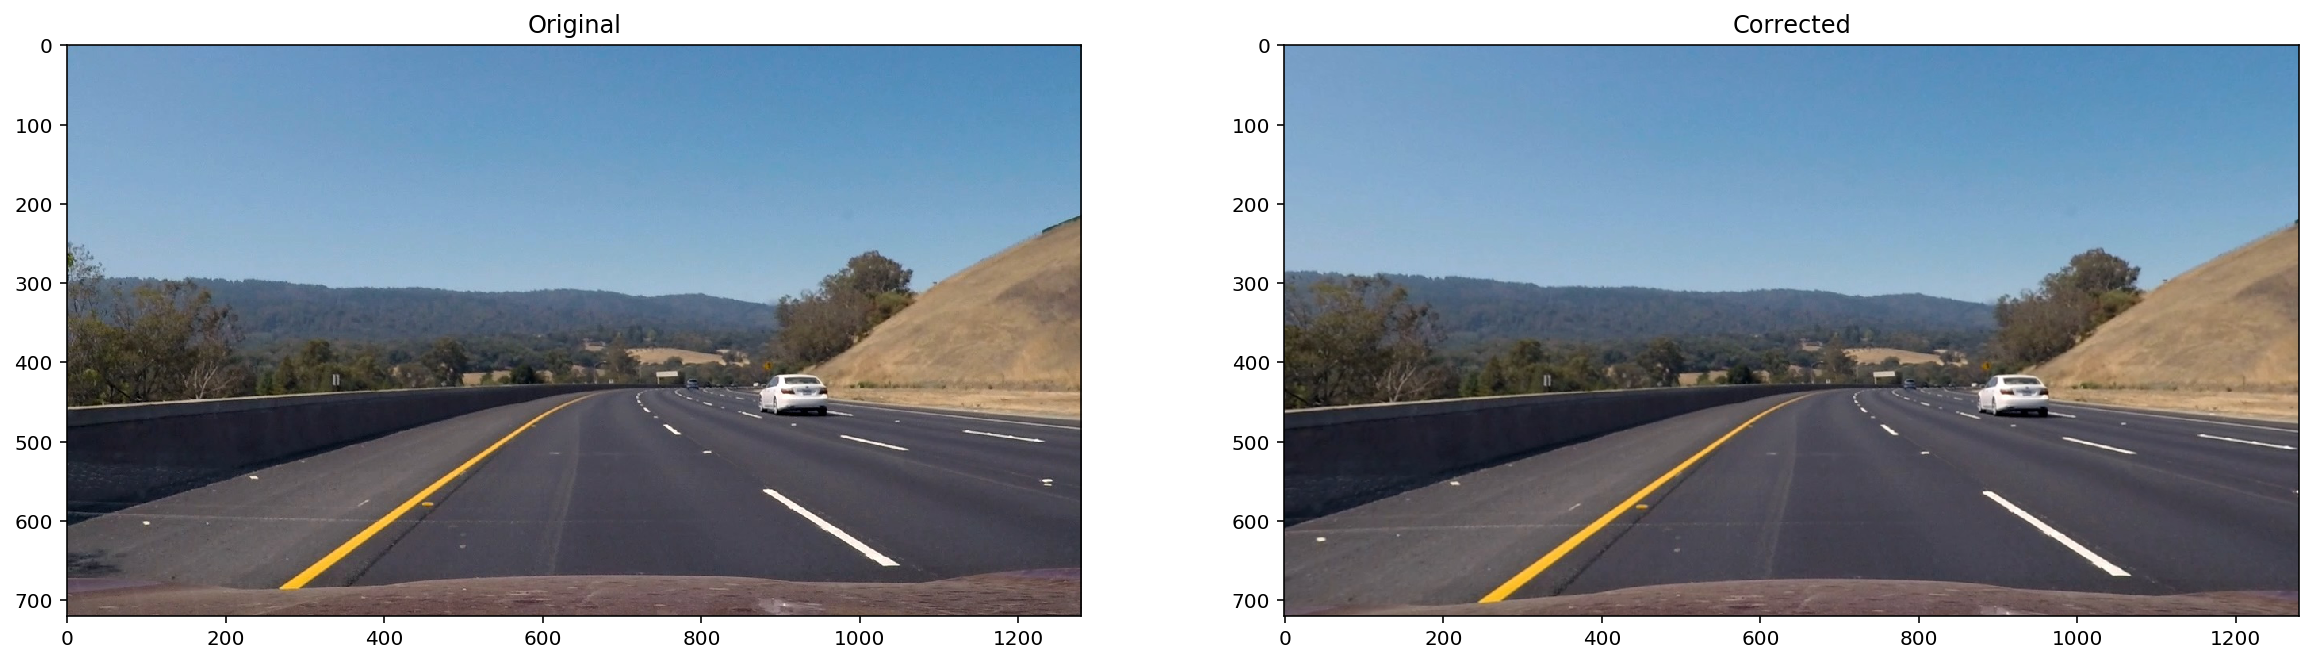

In [55]:
fig = plt.figure(figsize=(20, 10))

img = cv2.imread('test_images/test3.jpg')
fig.add_subplot(1, 2, 1).set_title('Original')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

camera = Camera()
image = camera.imread('test_images/test3.jpg')  # The image is automatically corrected

fig.add_subplot(1, 2, 2).set_title('Corrected')
image.show()

## Color & Gradient Threshold

All the color and gradient process methods are encapsulated inside the Image class on model.py

Properties:
- RGB, HLS: Color spaces 
- H, L ,S: Channels 

Methods:
- threshold(lo, hi)
- sobel(vertical, horizontal, length, angle, kernel=3): Gradient thresholds on direction, magnitude and direction

Operators (combine binary images):
- \_\_and__
- \_\_or__


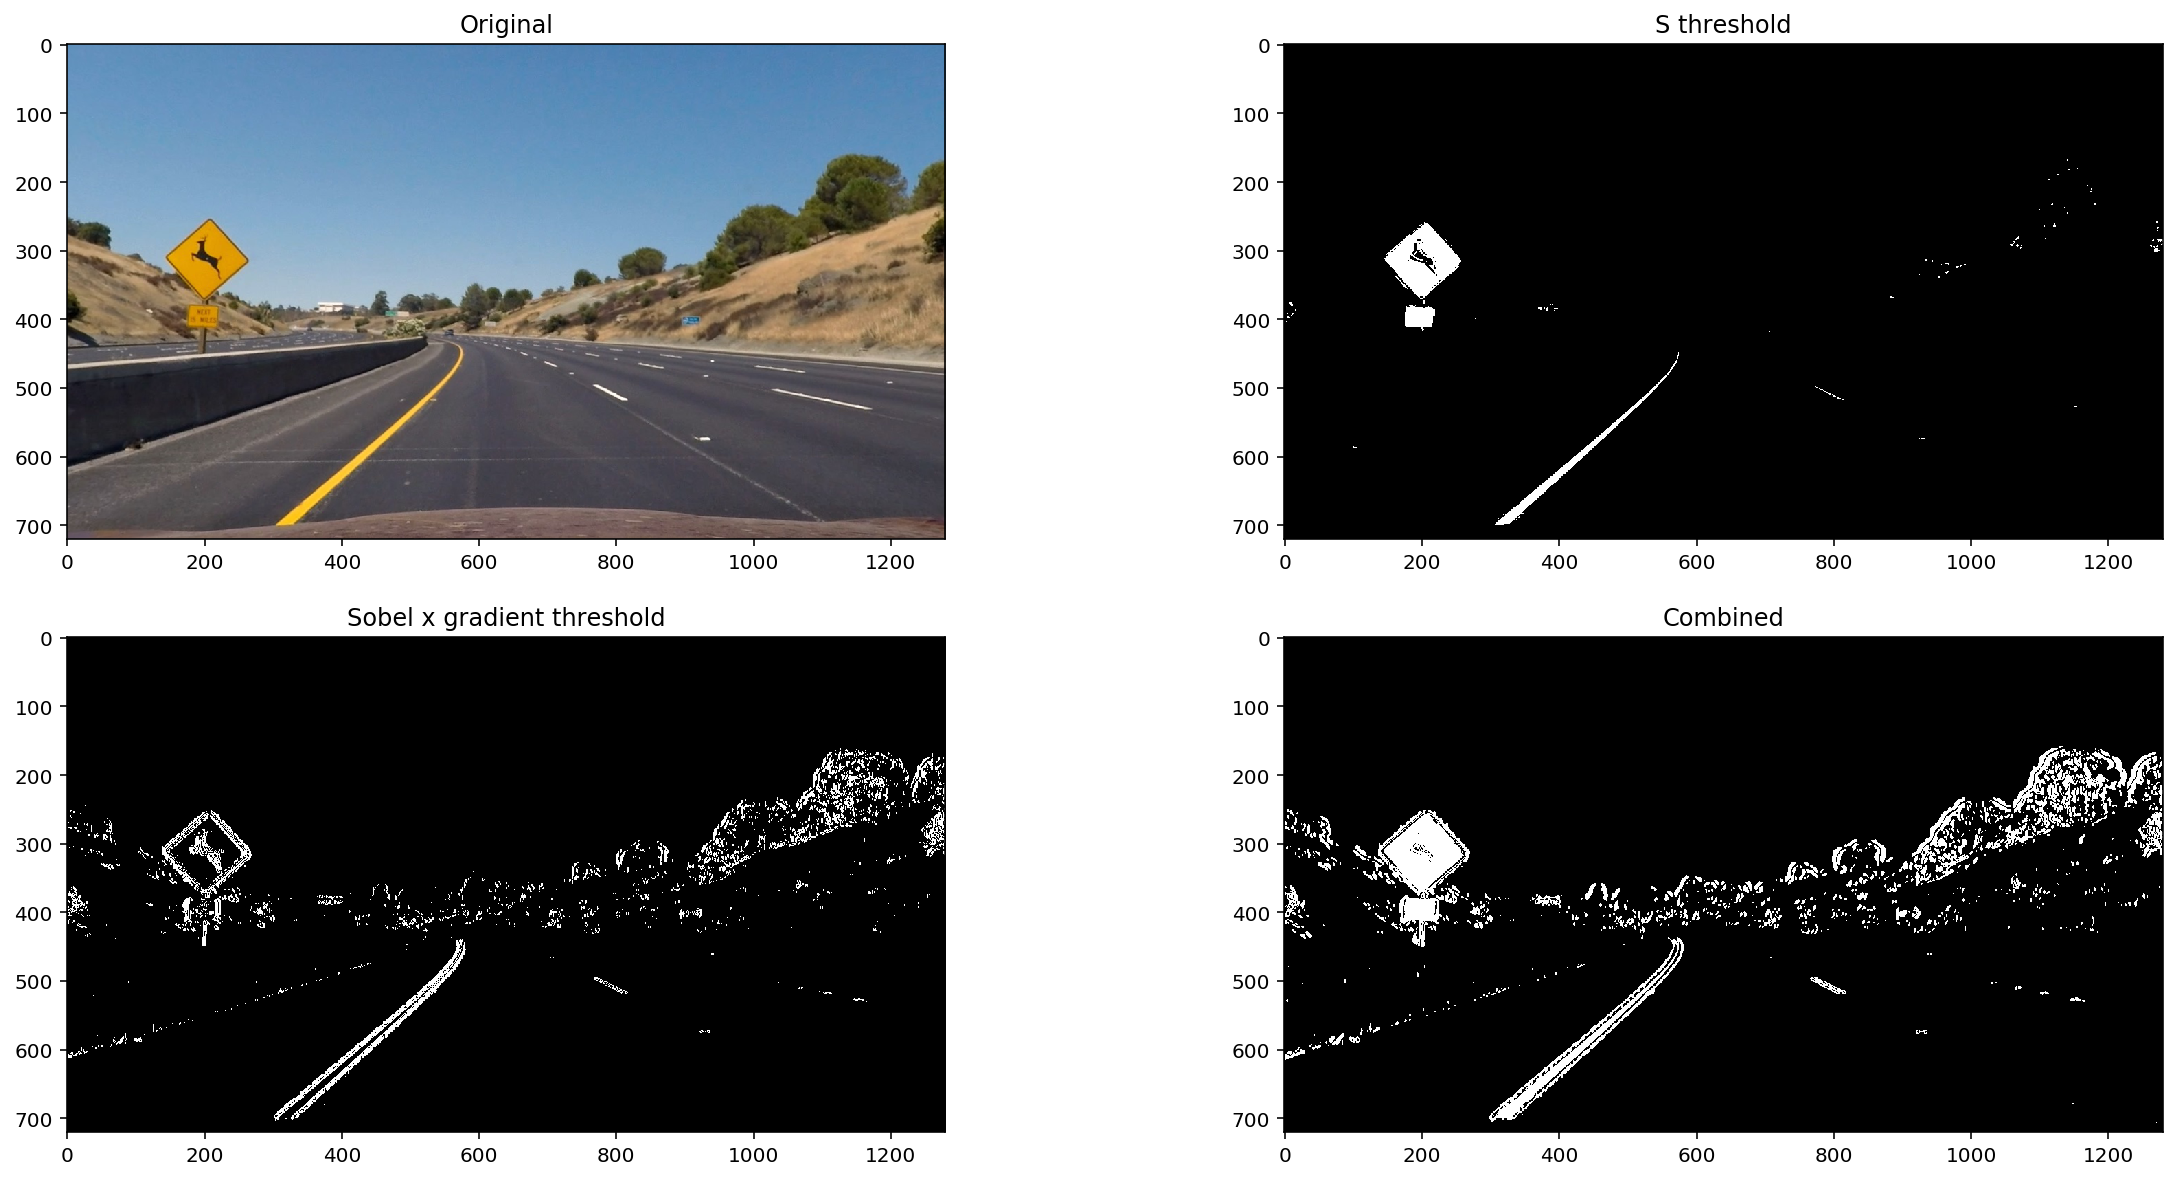

In [15]:
import matplotlib.pyplot as plt
from model import Camera

camera = Camera()
image = camera.imread('test_images/test2.jpg')

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(2, 2, 1).set_title('Original')
image.show()

fig.add_subplot(2, 2, 2).set_title('S threshold')
# S threshold
image.S.threshold(200, 255).show()

fig.add_subplot(2, 2, 3).set_title('Sobel x gradient threshold')
# Sobel x gradient threshold
image.S.sobel(vertical=(20, 100)).show()

fig.add_subplot(2, 2, 4).set_title('Combined')
# Combined S channel and gradient threshold
(image.S.threshold(170, 255) | image.S.sobel(vertical=(20, 100), kernel=9)).show()


## Perspective Transform

We choose four source points manually from a straight road image and apply a perspective transform.

In [53]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from model import Camera

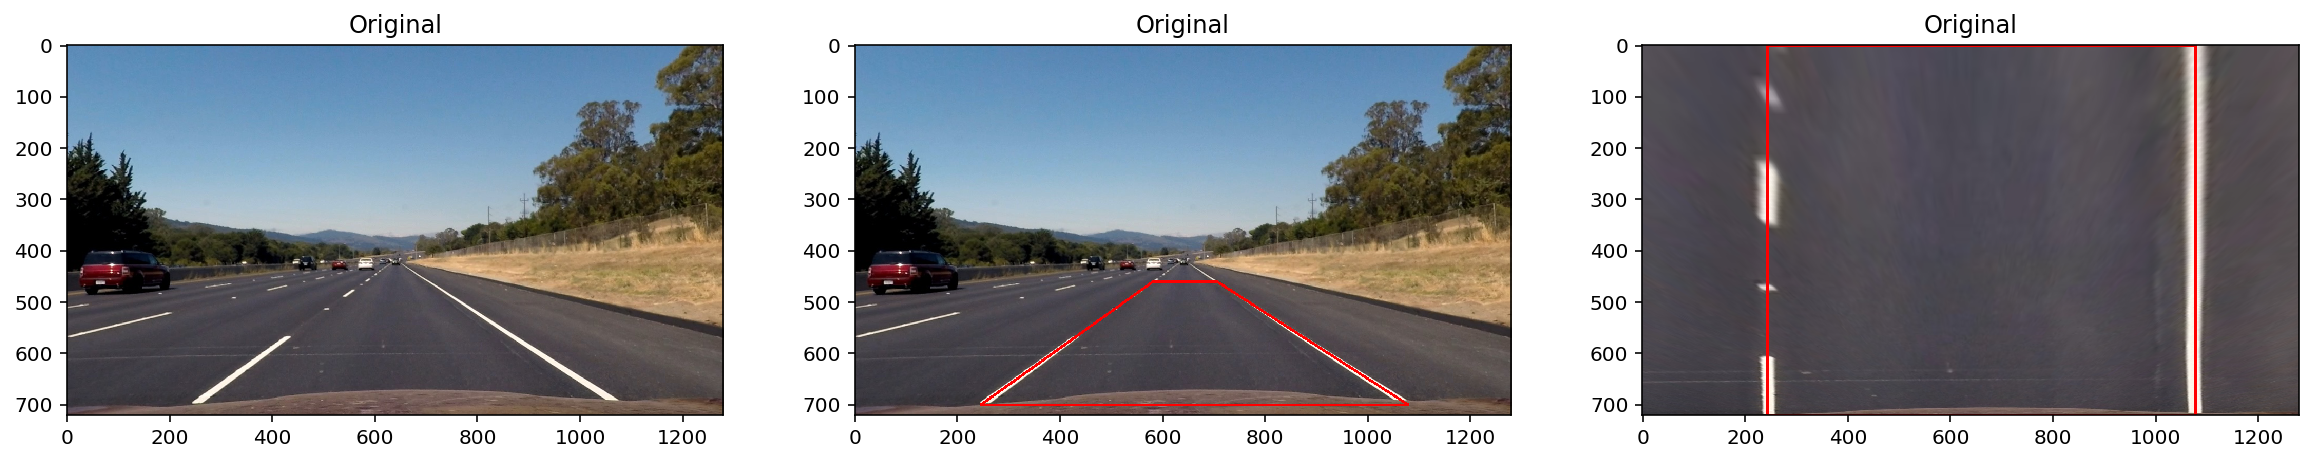

In [18]:
fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1).set_title('Original')

image = Camera().imread('test_images/straight_lines2.jpg')
image.show()

wp_src = np.float32([
    [705, 460],
    [1078, 700], 
    [244, 700], 
    [580, 460]
])

fig.add_subplot(1, 3, 2).set_title('Original')
img = image.RGB.pixels
cv2.line(img, tuple(wp_src[0]), tuple(wp_src[1]), [255, 0, 0], 4)
cv2.line(img, tuple(wp_src[1]), tuple(wp_src[2]), [255, 0, 0], 4)
cv2.line(img, tuple(wp_src[2]), tuple(wp_src[3]), [255, 0, 0], 4)
cv2.line(img, tuple(wp_src[3]), tuple(wp_src[0]), [255, 0, 0], 4)
plt.imshow(img)


wp_dst = np.float32([
    [1078, 0],
    [1078, 720],
    [244, 720],
    [244, 0]
])


M = cv2.getPerspectiveTransform(wp_src, wp_dst)
fig.add_subplot(1, 3, 3).set_title('Warped')
img = image.RGB.pixels
warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)

cv2.line(warped, tuple(wp_dst[0]), tuple(wp_dst[1]), [255, 0, 0], 4)
cv2.line(warped, tuple(wp_dst[1]), tuple(wp_dst[2]), [255, 0, 0], 4)
cv2.line(warped, tuple(wp_dst[2]), tuple(wp_dst[3]), [255, 0, 0], 4)
cv2.line(warped, tuple(wp_dst[3]), tuple(wp_dst[0]), [255, 0, 0], 4)

plt.imshow(warped)


#### Image.warp()
Perspective transform logic is included on the warp method of the Image class.

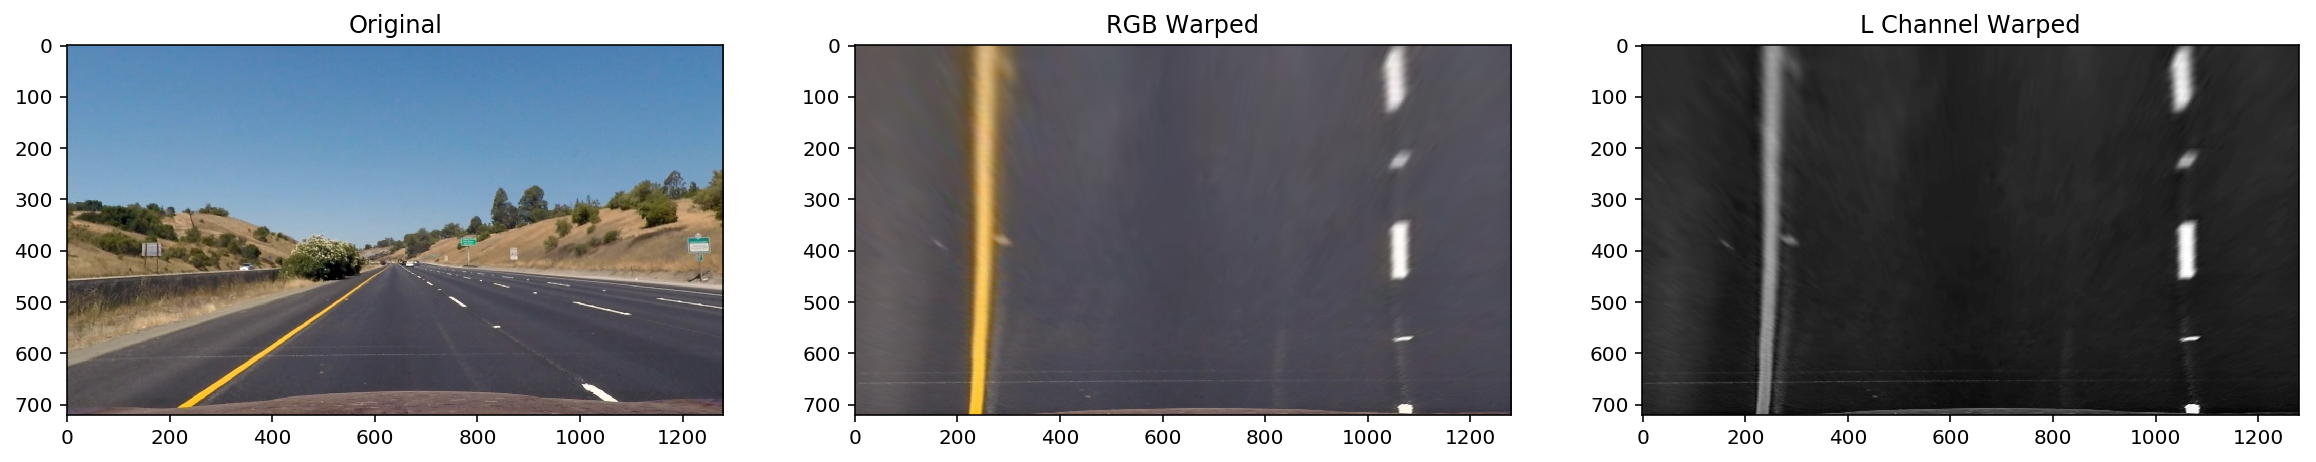

In [20]:
image = Camera().imread('test_images/straight_lines1.jpg')

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 3, 1).set_title('Original')
image.show()

fig.add_subplot(1, 3, 2).set_title('RGB Warped')
image.warp().show()

fig.add_subplot(1, 3, 3).set_title('L Channel Warped')
image.L.warp().show()

## Detect lane lines

Line class

- fit()
- adjust(left, rigth)

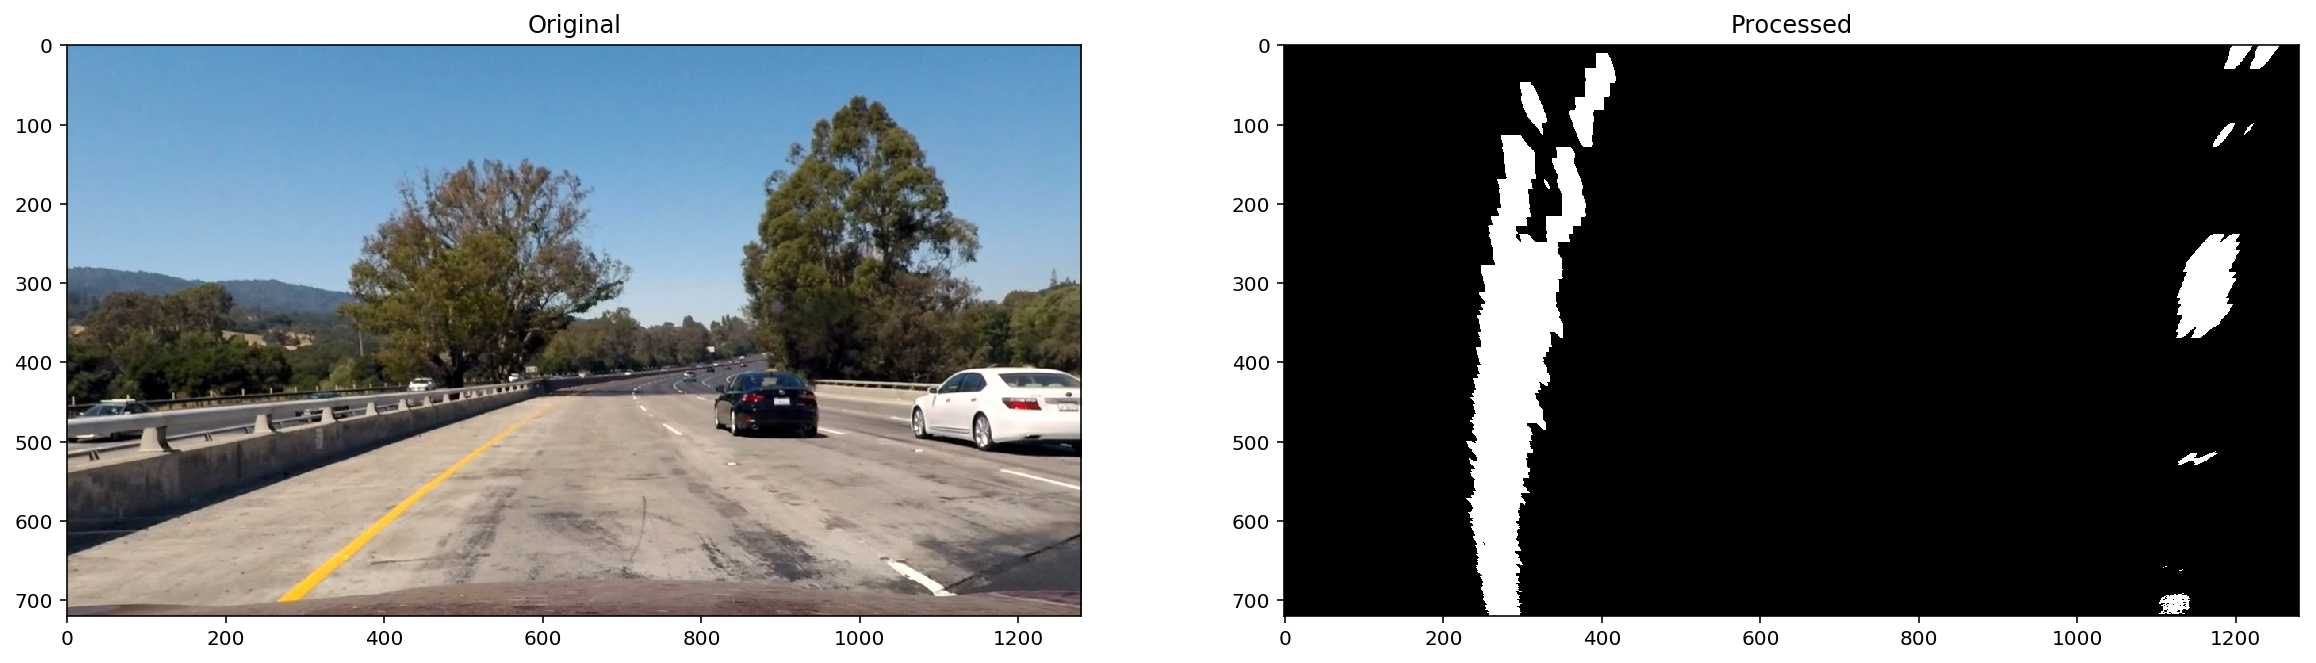

In [39]:
import matplotlib.pyplot as plt
from model import Camera

camera = Camera()
image = camera.imread('test_images/test1.jpg')

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).set_title('Original')
image.show()

fig.add_subplot(1, 2, 2).set_title('Processed')
binary = (image.S.threshold(170, 255) | image.S.sobel(vertical=(20, 100), kernel=9)).warp()
binary.show()


### Fit

It finds the lines by:

- Finding peaks in the image's histogram
- Use a sliding window to locate line pixels close to the peak

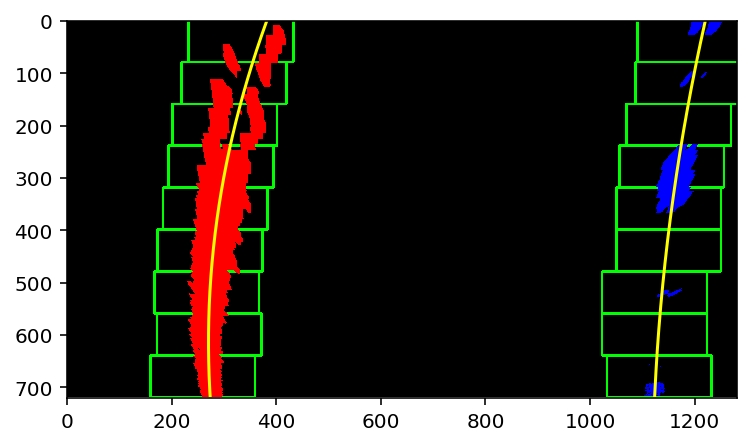

In [42]:
left, right = binary.fit(debug=True)


### Adjust

It skips the sliding windows step once we know where the lines are.

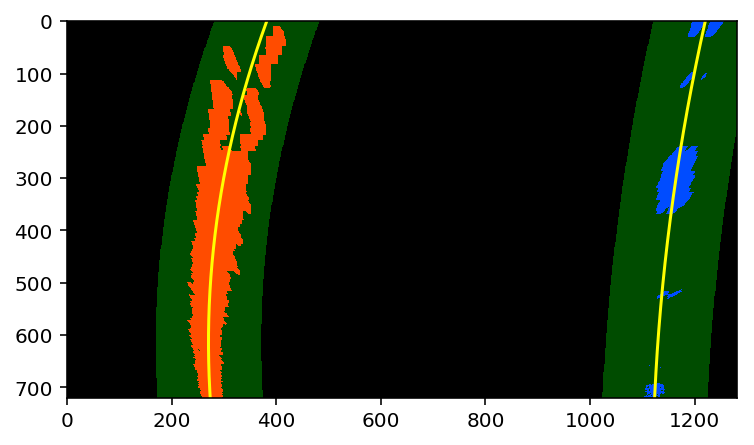

In [43]:
left, right = binary.adjust(left, right, debug=True)

### Radius & Position

Line class on model.py has the following properties:
    
- curvature

- position

In [1]:
from model import Camera, LaneFinder

finder = LaneFinder(camera=Camera())
finder.imread('test_images/test5.jpg')

print("Right line curvature {}m\nRight line distance to vehicle: {}m".format(
    finder.right.curvature, finder.right.position))

Right line curvature 696.0m
Right line distance to vehicle: 2.01m


##### LaneFinder and Line classes

Smoothing: Line class keeps a queue of the latest valid measurements 

Sanity Checks:
- Curvature > 500m
- Position < 3m

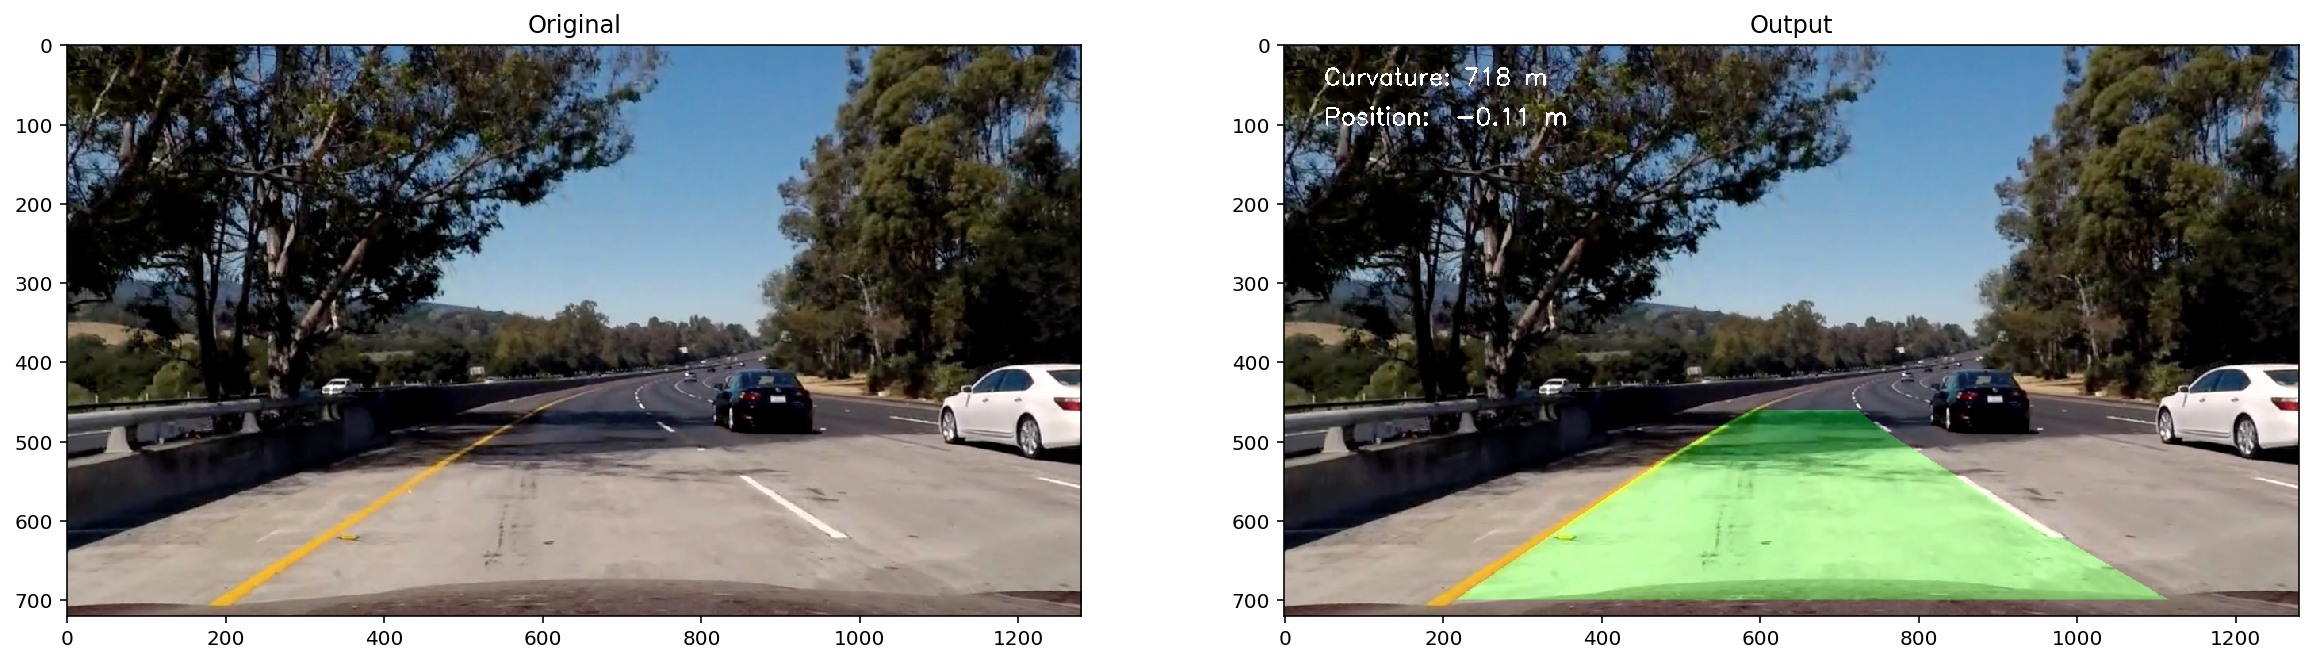

In [4]:
from model import Camera, LaneFinder

finder = LaneFinder(camera=Camera())

fig = plt.figure(figsize=(20, 10))
fig.add_subplot(1, 2, 1).set_title('Original')
image = finder.imread('test_images/test5.jpg')
image.show()

fig.add_subplot(1, 2, 2).set_title('Output')
finder.output.show()



### Video pipeline

In [5]:
from moviepy.editor import VideoFileClip

from model import Camera, LaneFinder

finder = LaneFinder(camera=Camera())


def process_image(image):
    return finder.run(image).pixels

clip = VideoFileClip('test_videos/project_video.mp4')
out_clip = clip.fl_image(process_image)
%time out_clip.write_videofile('output_video/project_video.mp4', audio=False)


[MoviePy] >>>> Building video output_video/project_video.mp4
[MoviePy] Writing video output_video/project_video.mp4


100%|█████████▉| 1260/1261 [10:28<00:00,  1.56it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video/project_video.mp4 

CPU times: user 9min 15s, sys: 1min 43s, total: 10min 59s
Wall time: 10min 32s


In [8]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="output_video/{0}">
</video>
""".format('output_video/project_video.mp4'))


## Discussion

### Current limitations

- Problem traking lines when the lighting conditions change.
- Use of approximations on pixel to meter conversions.
- Slow, needs a speed up more than 10x for real time processing.

### Possible improvements

- Dynamic thresholding: Based on the previous meaurements.
- Diferent filters for white/yellow lanes. 
- Line sanity checks:
    - Similar curvature
    - Separation
    - Parallel

